In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cuda


In [11]:
def cx_sigm(n=10, t_max=200):
    # rand_btw_7-30 * {-1, 1}
    c1 = (torch.rand(n, 1) * 23 + 7) #* torch.from_numpy(np.random.choice([-1, 1], (n, 1)))  # c1 for steepness
    t = torch.linspace(0, 1, t_max)
    c2 = 0.5  # c2 midpoint
    
    data = 1/(1 + torch.exp(-c1 * (t-c2)))
    return data


def generate_sin(x, amp=1, omega=1, eps=0.1):
    r1 = torch.rand(1)*(eps*2)+(1-eps)
    r2 = torch.rand(1)*(eps*2)+(1-eps)
    r3 = torch.rand(1)*(eps*2)+(1-eps)
    return r1*amp*torch.sin(x*omega+r2)+r3


def generate_cos(x, amp=1, omega=1, eps=0.1):
    r1 = torch.rand(1)*(eps*2)+(1-eps)
    r2 = torch.rand(1)*(eps*2)+(1-eps)
    r3 = torch.rand(1)*(eps*2)+(1-eps)
    return r1*amp*torch.cos(x*omega+r2)+r3


def generate_chainsaw(x, amp=1, mod=0.5, eps=0.1):
    r1 = torch.rand(1)*(eps*2)+(1-eps)
    r2 = torch.rand(1)*(eps*2)+(1-eps)
    r3 = torch.rand(1)*(eps*2)+(1-eps)
    return r1*amp*((x+r2) % (mod))+r3-amp/4


def generate_reverse_chainsaw(x, amp=1, mod=0.5, eps=0.1):
    r1 = torch.rand(1)*(eps*2)+(1-eps)
    r2 = torch.rand(1)*(eps*2)+(1-eps)
    r3 = torch.rand(1)*(eps*2)+(1-eps)
    return -r1*amp*((x+r2) % (mod))+r3+amp/4


t_steps = 200
num_demos = 100
num_val = 20
dx, dy = 1, 1
x = torch.linspace(0, 1, t_steps).repeat(int(num_demos/2), 1)

noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0) - 0.4
y0 = torch.unsqueeze(generate_chainsaw(x) + noise, 2)

noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0) - 0.4
y1 = torch.unsqueeze(generate_reverse_chainsaw(x) + noise, 2)

x = torch.unsqueeze(x.repeat(2,1), 2)
y = torch.cat((y0, y1), 0)
print("X:", x.shape, "Y:", y.shape)

path = "."

#######################################

vx = torch.linspace(0, 1, t_steps).repeat(int(num_val/2), 1)
vnoise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0) - 0.4
# vy0 = torch.unsqueeze(torch.sin(vx*torch.pi) + vnoise, 2)
vy0 = torch.unsqueeze(generate_chainsaw(vx) + vnoise, 2)

vnoise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0) - 0.4
# vy1 = cx_sigm(int(num_val/2), t_steps).view(int(num_val/2), t_steps, 1)
# vy1 += torch.unsqueeze(vnoise, 2)
vy1 = torch.unsqueeze(generate_reverse_chainsaw(vx) + vnoise, 2)

vx = torch.unsqueeze(vx.repeat(2,1), 2)
vy = torch.cat((vy0, vy1), 0)
print("vX:", vx.shape, "vY:", vy.shape)

X: torch.Size([100, 200, 1]) Y: torch.Size([100, 200, 1])
vX: torch.Size([20, 200, 1]) vY: torch.Size([20, 200, 1])


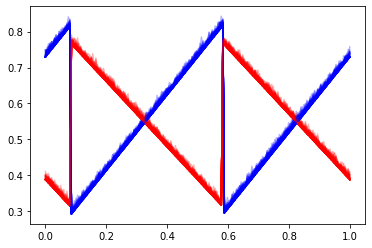

In [12]:
for i in range(int(num_demos/2)):
    plt.plot(x[i, :, 0], y[i, :, 0], 'b', alpha=0.3)
    plt.plot(x[i+int(num_demos/2), :, 0], y[i+int(num_demos/2), :, 0], 'r', alpha=0.3)
plt.show()

In [13]:
n_max = 16

def sample_training_demonstration():    
    rand_traj_ind = np.random.randint(0, num_demos)
    n = np.random.randint(1, n_max+1)

    rand_traj = y[rand_traj_ind, :, :]

    observation_indices = np.random.choice(np.arange(t_steps), n+1, replace=False) # n+1: +1 is for sampling the target
    
    observations = torch.cat((rand_traj[observation_indices[:-1], :], 
                              x[rand_traj_ind, observation_indices[:-1], :]), 1)
    targetX = torch.unsqueeze(torch.Tensor(x[rand_traj_ind, observation_indices[-1], :]), 0)
    targetY = torch.unsqueeze(torch.Tensor(rand_traj[observation_indices[-1], :]), 0)
    
    if device.type == 'cuda':
        return observations.float().cuda(), targetX.float().cuda(), targetY.float().cuda()
    else:
        return observations.float(), targetX.float(), targetY.float()


def get_validation_demonstration(ind):
    x = vx[ind, :, :]
    y = vy[ind, :, :]
    
    if device.type == 'cuda':
        return x.float().cuda(), y.float().cuda()
    else:
        return x, y

In [14]:
class BCNP(nn.Module):
    def __init__(self, in_shape, num_decoders):
        super(BCNP, self).__init__()
        
        self.num_decoders = num_decoders
        dx, dy = in_shape[0], in_shape[1]
        
        dz = 128
        dzt = dz+dx
        
        self.encoder = nn.Sequential(
            nn.Linear(dx+dy, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, dz)
        )
        
        self.gate = nn.Sequential(
            nn.Linear(dz, self.num_decoders),
            nn.Softmax(dim=-1)
        )
        
        decoders = []
        for i in range(self.num_decoders):
            decoders.append(nn.Sequential(
                nn.Linear(dzt, 128),
                nn.ReLU(),
                nn.Linear(128, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, dy*2)
                )
            )
            
        self.decoders = nn.ModuleList(decoders)
        

    def forward(self, observations, target):
        z_out = self.encoder(observations)
        z = torch.mean(z_out, dim=0)

        zs = z.repeat(target.shape[0], 1).to(device)  # repeating the same z for each target
        z_target = torch.cat((zs, target), 1)
        
        dec_out = torch.zeros(self.num_decoders, dy*2).float().to(device)
        for i in range(self.num_decoders):
            dec_out[i] = self.decoders[i](z_target)
            
        gate_out = self.gate(z)
        
        return dec_out, gate_out


def log_prob_loss(ty, ty_pred):
    m, s = ty_pred.chunk(2, dim = -1)
    s = F.softplus(s)
    dist = D.Independent(D.Normal(loc=m, scale=s), 1)
    return -torch.mean(dist.log_prob(ty))


def min_ent_lp_loss(ty, ty_preds, gate_preds):
    num_decoders = ty_preds.shape[0]
    losses = torch.zeros(num_decoders, 1)
    
    for i in range(num_decoders):
        losses[i] = log_prob_loss(ty, ty_preds[i]) * gate_preds[i]
        
    return torch.sum(losses)
        


def plot_trajs(path, i, x, y, pt, col):    
    plt.plot(x, y, 'k', alpha=0.5)
    plt.plot(x, pt[:, 0], col, alpha=0.75)
    plt.savefig(path+str(i)+'.png')    
    plt.close()


def validate(plot=False, path='', it=-1):
    verr=torch.zeros(num_val)
    
    with torch.no_grad():
        for i in range(num_val):
            val_x, val_y = get_validation_demonstration(i)

            cond_step = 0
            observation = torch.Tensor([val_y[cond_step, :], val_x[cond_step, :]]).view(1, dx+dy).float().cuda()
            
            pred_traj0, pred_traj1 = torch.zeros_like(val_y), torch.zeros_like(val_y)
            pred_traj0[cond_step, :] = val_y[cond_step, :]
            pred_traj1[cond_step, :] = val_y[cond_step, :]

            for t in range(1, t_steps):
                dec_out, _ = model(observation, torch.unsqueeze(val_x[t], 0))
                pred0, pred1 = dec_out[0], dec_out[1]
                pred_traj0[t, :], _ = pred0.chunk(2, dim = -1)  # pred[0]: mean, pred[1]: std
                pred_traj1[t, :], _ = pred1.chunk(2, dim = -1)
            
            verr0, verr1 = torch.sum((val_y - pred_traj0) ** 2), torch.sum((val_y - pred_traj1) ** 2)
#             print(f'v0: {verr0}\nv1: {verr1}')
            if verr0 < verr1:
                verr[i] = verr0
                if plot:
                    plot_trajs(path, i, val_x.cpu(), val_y.cpu(), pred_traj0.cpu(), 'r')
            else:
                verr[i] = verr1
                if plot:
                    plot_trajs(path, i, val_x.cpu(), val_y.cpu(), pred_traj1.cpu(), 'b')
            
    return torch.mean(verr)

In [ ]:
root_path = f'val/{int(time.time())}'

model = BCNP((1, 1), 2)
model.to(device)

optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters(), betas=(0.9, 0.999), amsgrad=True)

val_after_iter = 2500
plot_after_iter = 25000
iters = 10000000

losses = []
min_verr = 1e6
epsilon = 0.1

for i in range(iters):
    obss, tx, ty = sample_training_demonstration()
    
    optimizer.zero_grad()
    ty_preds, gate_preds = model(obss, tx)
#     print('G: ', end='')
#     print(gate_preds)
#     loss0, loss1 = log_prob_loss(ty, ty_preds[0]), log_prob_loss(ty, ty_preds[1])
    
    loss = min_ent_lp_loss(ty, ty_preds, gate_preds)
    loss.backward()
    
#     if torch.rand(1) < epsilon and i < 100000:
#         if torch.rand(1) < 0.5:
#             model.decoders[0].requires_grad = True
#             model.decoders[1].requires_grad = False
#             loss0.backward()
#         else:
#             model.decoders[0].requires_grad = False
#             model.decoders[1].requires_grad = True
#             loss1.backward()
#     else:
#         if loss0 < loss1:
#             model.decoders[0].requires_grad = True
#             model.decoders[1].requires_grad = False
#             loss0.backward()
#         else:
#             model.decoders[0].requires_grad = False
#             model.decoders[1].requires_grad = True
#             loss1.backward()
    
    optimizer.step()
    if i%500 == 0:
        print(f'{i}: {loss}')
    
    if i%val_after_iter == 0:
        if i%plot_after_iter == 0:
            d_path = f'{root_path}/{str(i)}/'
            try:
                os.makedirs(d_path)
            except:
                pass
            verr = validate(True, d_path, i)
        else:
            verr = validate()
        print(f"Val - {i}: {verr}")
        losses.append(verr)

        if verr < min_verr:
            min_verr = verr
            print(f"Best validation")
            torch.save(model.state_dict(), f'{root_path}/best_model.pt')

0: 0.7768857479095459
0: 75.01002502441406
Best validation
500: -0.894839346408844
1000: -0.8549776673316956
1500: -0.6892977952957153
2000: -0.2302076369524002
2500: -0.7685598134994507
2500: 7.8993730545043945
Best validation
3000: -0.36015793681144714
3500: 0.29744434356689453
4000: -1.0247870683670044
4500: -1.0399247407913208
5000: -0.7363865375518799
5000: 7.115987300872803
Best validation
5500: -0.5820158123970032
6000: -0.9061580300331116
6500: -0.6624971032142639
7000: -0.1682484745979309
7500: -0.7660248279571533
7500: 4.212867736816406
Best validation
8000: -0.983833372592926
8500: -0.7912580966949463
9000: -1.095813274383545
9500: -0.8143771290779114
10000: -0.4972008168697357
10000: 6.511283874511719
10500: -0.13136957585811615
11000: -0.9177042245864868
11500: -0.7477395534515381
12000: -0.6134777069091797
12500: -0.7168809771537781
12500: 5.507992744445801
13000: -0.19798745214939117
13500: -0.20212553441524506
14000: -0.7413402199745178
14500: -0.35257551074028015
15000

126000: -1.164505124092102
126500: -0.4024852514266968
127000: -1.5192878246307373
127500: -1.934183120727539
127500: 4.906155586242676
128000: -0.7110162973403931
128500: -0.22298626601696014
129000: -0.161153644323349
129500: -2.5944838523864746
130000: -0.05703543499112129
130000: 5.027645111083984
130500: -0.47749438881874084
131000: -0.21781036257743835
131500: -0.4709761440753937
132000: -3.059767007827759
132500: -2.5572099685668945
132500: 5.300141334533691
133000: -1.1395363807678223
133500: -1.8248343467712402
134000: -1.3924357891082764
134500: -0.2672611474990845
135000: -1.7547663450241089
135000: 5.2284722328186035
135500: -2.2752110958099365
136000: -0.5390335917472839
136500: -1.6075916290283203
137000: -0.9196869134902954
137500: -0.3835184872150421
137500: 5.436159610748291
138000: -0.1771073192358017
138500: -1.9581010341644287
139000: -0.7342338562011719
139500: -0.23046237230300903
140000: 0.26921045780181885
140000: 5.011198997497559
140500: -0.8633603453636169
14

250500: -1.3587908744812012
251000: -2.0267040729522705
251500: -0.7558658719062805
252000: -0.7895075082778931
252500: -3.5170626640319824
252500: 6.186572074890137
253000: -3.736778974533081
253500: -3.4344329833984375
254000: -2.2356348037719727
254500: -3.4329640865325928
255000: -1.23532235622406
255000: 6.266436576843262
255500: -3.4516172409057617
256000: -2.634063482284546
256500: -2.534088373184204
257000: 129.83367919921875
257500: -3.289633274078369
257500: 6.251359462738037
258000: 0.05519784241914749
258500: -3.5992720127105713
259000: -0.22875477373600006
259500: -2.2622978687286377
260000: -3.3905563354492188
260000: 5.457552909851074
260500: 0.5290361642837524
261000: -2.5310370922088623
261500: -3.2607126235961914
262000: 0.6644688844680786
262500: -3.347982883453369
262500: 5.745285987854004
263000: -3.1109559535980225
263500: -2.547661542892456
264000: -3.0370919704437256
264500: -2.823776960372925
265000: -0.672366201877594
265000: 5.923558235168457
265500: -3.80744

376000: -1.0938305854797363
376500: 0.12477637827396393
377000: -2.712489366531372
377500: -3.489497184753418
377500: 6.253343105316162
378000: -0.7025146484375
378500: -3.5342860221862793
379000: -3.908416986465454
379500: -3.0942087173461914
380000: -0.9835765361785889
380000: 6.886175632476807
380500: -3.4845387935638428
381000: -3.892683267593384
381500: -3.6273980140686035
382000: -3.5624074935913086
382500: -3.559251070022583
382500: 6.303399085998535
383000: -2.403162956237793
383500: -2.4762136936187744
384000: -2.0277068614959717
384500: -2.013195514678955
385000: -3.5089683532714844
385000: 6.410327911376953
385500: -3.215816020965576
386000: -3.344959259033203
386500: -3.2871408462524414
387000: -3.817673683166504
387500: -3.8547234535217285
387500: 6.095113754272461
388000: -2.5888638496398926
388500: -1.2917680740356445
389000: -2.8879878520965576
389500: -3.5168440341949463
390000: -0.9863862991333008
390000: 7.623817443847656
390500: -3.6130259037017822
391000: -2.042302

501500: -3.525803804397583
502000: -3.5030064582824707
502500: -2.414799690246582
502500: 7.340584754943848
503000: -2.0483744144439697
503500: -2.65521240234375
504000: -1.7384631633758545
504500: -2.373406410217285
505000: -3.0696663856506348
505000: 6.272221088409424
505500: 1.0832680463790894
506000: -1.3026498556137085
506500: -0.617619514465332
507000: -3.084301233291626
507500: -2.7129390239715576
507500: 7.738535404205322
508000: -0.3662746250629425
508500: -2.405252695083618
509000: -3.4102137088775635
509500: -3.684551954269409
510000: -1.2274235486984253
510000: 7.34546422958374
510500: -3.4625942707061768
511000: -3.210158109664917
511500: -2.010335683822632
512000: -1.6543537378311157
512500: -3.512063980102539
512500: 7.053868293762207
513000: -3.4155197143554688
513500: -3.3194797039031982
514000: 1.6028165817260742
514500: 0.37027886509895325
515000: -3.365760087966919
515000: 7.0007829666137695
515500: -1.443163514137268
516000: -3.9732089042663574
516500: -2.152616262